In [1]:
import numpy as np
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from urllib.request import urlopen
import string
import json

In [2]:
import gensim

In [3]:
# In the following, I've decided to take out the most common words, which may not convey much meaning: stop words
stop_words = stopwords.words('english')

In [4]:
stop_words.extend(['would','said'])

In [5]:
# We're going to use the pre-trained Word2Vec model from Google.  The file below shows up as 3.64GB!
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

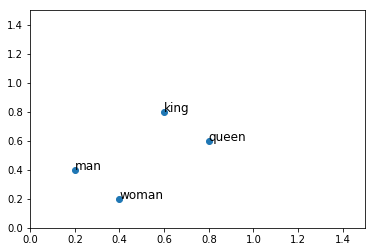

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb  
import numpy as np

words = ['king','queen', 'man', 'woman']  


vectors = np.array([[0.6,   0.8], 
                    [0.8, 0.6],
                   [.2,.4],[.4,.2]]
                 ) 

plt.plot(vectors[:,0], vectors[:,1], 'o')  
plt.xlim(0, 1.5)  
plt.ylim(0, 1.5)  
for word, x, y in zip(words, vectors[:,0], vectors[:,1]):
    plt.annotate(word, (x, y), size=12)
    
# Notice how the vector from queen to king and the vector from woman to man are both in the same direction?
# This illustrates the idea that the word embedding captures meaning of the words. The vector from queen to king
# is just v_king - v_queen, that is the difference.  The difference between a king and a queen is is simply the
# gender.  Similarly with the difference between man and woman.  So the direction of the vector is simply the 
# gender direction in this simple 2-D example.

In [17]:
len(model['computer']) # Each word is represented by a 300-dimensional numerical vector

300

In [18]:
model.most_similar('king',topn=4)

[('kings', 0.7138045430183411),
 ('queen', 0.6510956883430481),
 ('monarch', 0.6413194537162781),
 ('crown_prince', 0.6204219460487366)]

In [19]:
model.doesnt_match("breakfast soldier cowboy warrior".split())

'breakfast'

In [32]:
# Similarity
model.similarity('woman','man')

0.7664012230995352

In [29]:
# Compute cosine_similarity
model.n_similarity(['woman', 'girl'], ['man', 'boy'])

0.8224723253480029

In [24]:
# king - man + woman = ? should give you 'queen' as the most likely result.
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133)]

In [25]:
# Even does grammar!  biggest - big + small = ? should give you 'smallest' as the most likely result.
model.most_similar(positive=['biggest','small'], negative=['big'], topn=5)

[('smallest', 0.6086567640304565),
 ('largest', 0.6007465124130249),
 ('tiny', 0.5387297868728638),
 ('large', 0.45694398880004883),
 ('minuscule', 0.4340195059776306)]

In [26]:
# Past tense.  ate - eat + speak = ? should give you 'spoke' as the most likely result.
model.most_similar(positive=['ate','speak'], negative=['eat'], topn=5)

[('spoke', 0.6965223550796509),
 ('speaking', 0.6261292099952698),
 ('conversed', 0.5754592418670654),
 ('spoken', 0.5704882740974426),
 ('speaks', 0.5630601644515991)]

In [79]:
# Promising result.  Obviously, recent US politics has little to do with food.
model.n_similarity(['trump','clinton','election'], ['cake','lasagna','cheese'])

0.10096702252728725

In [6]:
def load_borowitz():
    with open('final_borowitz_glove.json', 'r') as fp:
        borowitz = json.load(fp)
        fp.close()
        borowitz_articles = []
        for article in borowitz:
            article[3] = [word for word in article[3] if word in word_vectors.vocab]
            borowitz_articles.append(article[3])
    return borowitz, borowitz_articles

In [7]:
word_vectors = model.wv

/Users/velocci/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [8]:
borowitz, borowitz_articles = load_borowitz()

In [9]:
def get_onion_text(page_url):
    page = urlopen(page_url)
    soup = BeautifulSoup(page, "html.parser")
    stuff = soup.find_all("p", attrs={"class":None})
    article_text = ""
    for things in stuff:
        blah = things.text.strip()
        article_text += blah + ' '
    article_text = "".join((char.lower() for char in article_text if char not in string.punctuation))
    article_text = article_text.replace('"', " ").replace("'",'').replace('“',' ').replace('”',' ').replace("’",'').replace('-',' ').replace('--',' ').replace('—',' ').replace('…',' ')
    article_text = [word for word in article_text.split() if word not in stop_words]
    article_text = [word for word in article_text if word in word_vectors.vocab]
    return article_text

def get_nytimes_text(page_url):
    page = urlopen(page_url)
    soup = BeautifulSoup(page, "html.parser")
    stuff = soup.find_all("div", attrs={"class":"css-18sbwfn StoryBodyCompanionColumn"}) # Updated August 9, 2018
    article_text = ""
    for things in stuff:
        blah = things.text.strip()
        article_text += blah + ' '
    article_text = "".join((char.lower() for char in article_text if char not in string.punctuation))
    article_text = article_text.replace('"', " ").replace("'",'').replace('“',' ').replace('”',' ').replace("’",'').replace('-',' ').replace('--',' ').replace('—',' ').replace('…',' ')
    article_text = [word for word in article_text.split() if word not in stop_words]
    article_text = [word for word in article_text if word in word_vectors.vocab]
    return article_text

def find_similar_borowitz(new_text):
    scores = []
    for borowitz_article in borowitz_articles:
        score = model.n_similarity(borowitz_article, new_text)
        scores.append(score)
    indices = [b[0] for b in sorted(enumerate(scores),key=lambda i:i[1], reverse=True)]
    i = indices[0]
    j = indices[1]
    return borowitz[i][0], borowitz[i][2], borowitz[j][0], borowitz[j][2], i, j

def which_newspaper(text):
    start_nyt = ['https://www.nytimes.com', 'http://www.nytimes.com', 'www.nytimes.com', 'https://mobile.nytimes.com', 'http://mobile.nytimes.com']
    http = ['http://', 'https://']
    if any(text.startswith(beginning) for beginning in start_nyt):
        return get_nytimes_text(text)
    elif any(text.startswith(beginning) for beginning in http) and 'theonion.com' in text:
        return get_onion_text(text)
    else:
        text = "".join((char.lower() for char in text if char not in string.punctuation))
        text = text.replace('"', " ").replace("'",'').replace('“',' ').replace('”',' ').replace("’",'').replace('-',' ').replace('--',' ').replace('—',' ').replace('…',' ')
        text = [word for word in text.split() if word not in stop_words]
        text = [word for word in text if word in word_vectors.vocab]
    return text

In [11]:
find_similar_borowitz(get_nytimes_text('https://www.nytimes.com/2018/08/14/technology/facebook-disinformation-black-elevation.html'))

('Facebook Unveils New Waste of Time | The New Yorker',
 'https://www.newyorker.com/humor/borowitz-report/facebook-unveils-new-waste-of-time',
 'No One in Nation Notices Total Disappearance of Chris Christie | The New Yorker',
 'https://www.newyorker.com/humor/borowitz-report/no-one-in-nation-notices-total-disappearance-of-chris-christie',
 757,
 309)

In [12]:
find_similar_borowitz(get_nytimes_text('https://www.nytimes.com/2018/08/14/us/catholic-church-sex-abuse-pennsylvania.html'))

('Scalia Says Marriage Views Not Affected by Lifelong Fear of Gays | The New Yorker',
 'https://www.newyorker.com/humor/borowitz-report/scalia-says-marriage-views-not-affected-by-lifelong-fear-of-gays',
 'Scalia Forms Search Committee for New Pope | The New Yorker',
 'https://www.newyorker.com/humor/borowitz-report/scalia-forms-search-committee-for-new-pope',
 763,
 695)

In [10]:
# Visualizing a few articles using t-SNE
from sklearn.manifold import TSNE

In [39]:
borowitz[0][0]

'Pence Calls Space Force Necessary to Protect U.S. from Gay Aliens | The New Yorker'

/Users/velocci/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


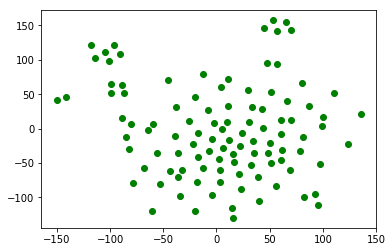

In [38]:
X_boro = model[borowitz_articles[0]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_boro)

plt.scatter(X_tsne[:,0], X_tsne[:,1], color='green')
plt.show()

In [37]:
borowitz[101][0]

'Kim Jong Un Fears That G.O.P. Tax Bill Makes His Plan to Destroy the U.S. Redundant | The New Yorker'

/Users/velocci/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


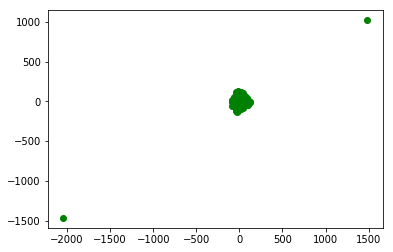

In [40]:
X_boro = model[borowitz_articles[101]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_boro)

plt.scatter(X_tsne[:,0], X_tsne[:,1], color='green')
plt.show()

In [41]:
borowitz[110][0]

'Virginia and New Jersey Elect Governors Totally Lacking Reality-Show Experience | The New Yorker'

/Users/velocci/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


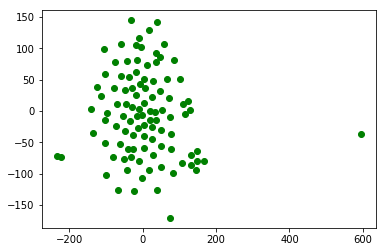

In [42]:
X_boro = model[borowitz_articles[110]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_boro)

plt.scatter(X_tsne[:,0], X_tsne[:,1], color='green')
plt.show()